# 지도학습 - 단순선형회귀

In [1]:
from hossam import load_data, my_dpi

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 데이터 표준화 모듈
from sklearn.preprocessing import StandardScaler
# 선형회귀분석 모듈
from sklearn.linear_model import LinearRegression
# 훈련/검증 데이터 분리 모듈
from sklearn.model_selection import train_test_split

c:\Users\wodyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.4.18

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.


In [2]:
origin = load_data('cars')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리

데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## 1. EDA + Preprocessing

In [3]:
# 기초 통계량
desc = origin.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0


In [4]:
# 결측치 여부
desc['missing'] = origin.isnull().sum()
desc

,count,mean,std,min,25%,50%,75%,max,missing
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0


In [5]:
# IQR, 이상치 경계, 이상치 수, 이상치 비율
Q1 = origin.quantile(0.25)
Q3 = origin.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_count = ((origin < lower_bound) | (origin > upper_bound)).sum()
outlier_ratio = outlier_count / len(origin) * 100
desc['outlier_count'] = outlier_count
desc['outlier_ratio(%)'] = outlier_ratio
desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%)
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0,0,0.0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0,1,2.0


In [6]:
# 왜도, 로그 변환 필요성 확인
skewness_results = []

for column in origin.columns:
    skewness = origin[column].skew()
    if abs(skewness) < 0.5:
        strength = 'week'
        log_transform = 'not needed'
    elif abs(skewness) < 1:
        strength = 'normal'
        log_transform = 'recommended'
    else:
        strength = 'strong'
        log_transform = 'needed'

    desc.loc[column, 'skewness'] = skewness
    desc.loc[column, 'skewness_strength'] = strength
    desc.loc[column, 'log_transform'] = log_transform

desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%),skewness,skewness_strength,log_transform
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0,0,0.0,-0.117510,week,not needed
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0,1,2.0,0.806895,normal,recommended


- dist 칼럼은 정규 분포를 따르지 않기 때문에 로그 변환이 필요

## 2. 로그변환

In [7]:
# dist에 대해서 로그 변환 수행
df = origin.copy()
df['dist'] = np.log1p(df['dist'])
df.head()

,speed,dist
0,4,1.098612
1,4,2.397895
2,7,1.609438
3,7,3.135494
4,8,2.833213


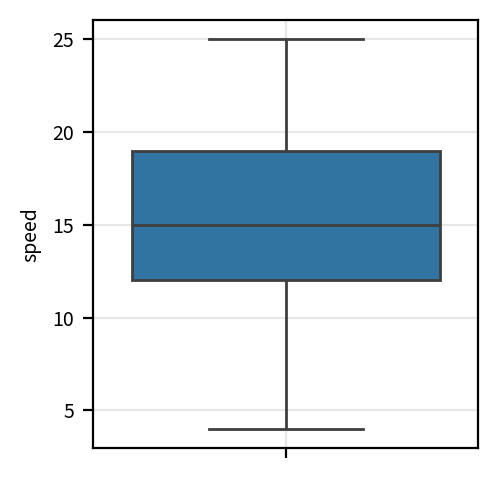

In [10]:
width_px = 500
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# box 그리기
sb.boxplot(data=df, y='speed')

# 그래프 꾸미기
ax.grid(True, alpha = 0.3) # 배경 격자 표시/숨김

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 3. 머신러닝을 위한 데이터 전처리

In [12]:
# 독립변수 분리
x = df[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [13]:
# 종속변수 분리
y = df['dist']
y.head()

0    1.098612
1    2.397895
2    1.609438
3    3.135494
4    2.833213
Name: dist, dtype: float64

In [14]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

display(x_train.head())
display(x_test.head())
display(y_train.head())
display(y_test.head())

(37, 1) (13, 1) (37,) (13,)


,speed
0,4
44,23
25,15
29,17
43,22


,speed
19,14
3,7
26,16
40,20
8,10


0     1.098612
44    4.007333
25    4.007333
29    3.713572
43    4.204693
Name: dist, dtype: float64

19    3.295837
3     3.135494
26    3.496508
40    3.970292
8     3.555348
Name: dist, dtype: float64

## 3. 데이터 분석
### 선형회귀 모델 구축

In [15]:
# 분석 알고리즘에 대한 객체 생성
estimator = LinearRegression(n_jobs = -1)

# 학습
estimator.fit(x_train, y_train)

print('계수(기울기):', estimator.coef_)
print('절편:', estimator.intercept_)
print('훈련 데이터 설명력:', estimator.score(x_train, y_train))
print('검증 데이터 설명력:', estimator.score(x_test, y_test))

계수(기울기): [0.12418778]
절편: 1.6126343404098376
훈련 데이터 설명력: 0.7126860464637156
검증 데이터 설명력: 0.4227254438591028


### 분석 결과 확인
#### 훈련 데이터에 대한 예측값 얻기

In [16]:
y1 = estimator.predict(x_train)
y1

array([2.10938547, 4.46895332, 3.47545107, 3.72382663, 4.34476554,
       2.48194881, 3.35126329, 3.35126329, 4.59314111, 2.6061366 ,
       2.85451216, 3.10288772, 3.72382663, 3.22707551, 4.59314111,
       2.97869994, 3.10288772, 4.59314111, 3.9722022 , 4.09638998,
       3.22707551, 4.09638998, 3.9722022 , 4.09638998, 3.84801441,
       4.09638998, 3.9722022 , 3.59963885, 4.59314111, 2.73032438,
       3.84801441, 4.71732889, 3.35126329, 3.47545107, 3.10288772,
       3.10288772, 3.72382663])

#### 검증 데이터에 대한 예측값 얻기

In [19]:
y2 = estimator.predict(x_test)
y2

array([3.35126329, 2.48194881, 3.59963885, 4.09638998, 2.85451216,
       2.97869994, 3.47545107, 2.85451216, 3.84801441, 3.84801441,
       3.22707551, 2.10938547, 3.22707551])

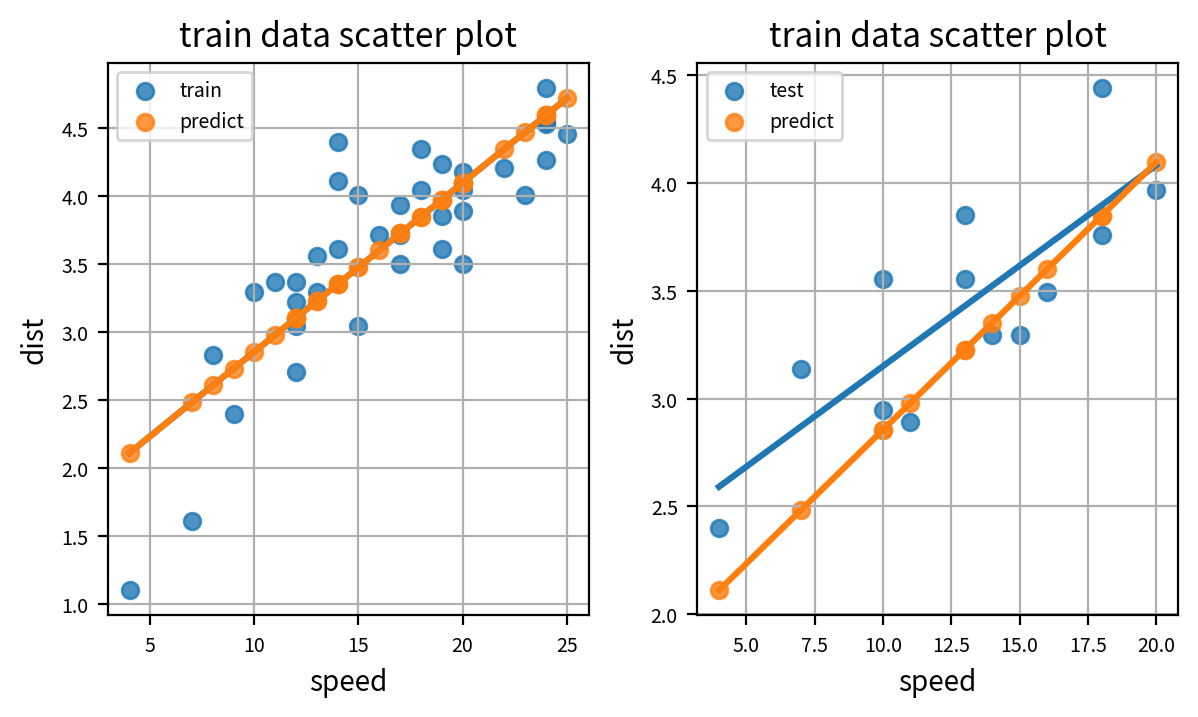

In [23]:
width_px = 1200
height_px = 720
rows = 1
cols = 2
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# bar 그리기
sb.regplot(data=x_train,             
           x = 'speed',            
           y =y_train,         
           ci = 0,              
           label ='train',
           ax=ax[0])        
sb.regplot(data=x_train,             
           x = 'speed',            
           y =y1,         
           ci = 0,              
           label ='predict',
           ax=ax[0])
ax[0].set_title('train data scatter plot', fontsize = 12)
ax[0].set_xlabel('speed', fontsize = 10)
ax[0].set_ylabel('dist', fontsize = 10)
ax[0].legend()    
ax[0].grid(True)

sb.regplot(data=x_test,             
           x = 'speed',            
           y =y_test,         
           ci = 0,              
           label ='test',
           ax=ax[1])        
sb.regplot(data=x_test,             
           x = 'speed',            
           y =y2,         
           ci = 0,              
           label ='predict',
           ax=ax[1])
ax[1].set_title('train data scatter plot', fontsize = 12)
ax[1].set_xlabel('speed', fontsize = 10)
ax[1].set_ylabel('dist', fontsize = 10)
ax[1].legend()    
ax[1].grid(True)
# 출력
plt.tight_layout()
plt.show()
plt.close()

## 4. 새로운 값 예측하기

In [24]:
# 새로운 관측값
new_X = DataFrame({'speed': [40], 'dist': [100]})

# 동일한 변환 적용
new_X['dist'] = np.log(new_X['dist'])
new_X = new_X[['speed','dist']]
new_X.head()

,speed,dist
0,40,4.60517


In [25]:
# 예측
y_pred = estimator.predict(new_X[['speed']])
new_X['dist_pred'] = y_pred
new_X

,speed,dist,dist_pred
0,40,4.60517,6.580146
